In [1]:
import copy
import numpy as np
import numpy.random as rand
import scipy.optimize
from scipy.stats import gamma
import matplotlib.pyplot as plt

In [2]:
TOKENS_NUM = 3 # Number of tokens
UTILITY_RANGES = np.array([10, 1, 1000]) # Upper limit of coefficients in utility function for each token. Lower limit is 0.
SCALING_FACTOR = 100.0 # "Dirty" trick for proper work of optimization algorithm
INCOME_VECTOR = np.array([1e5  / SCALING_FACTOR, 1e6 / SCALING_FACTOR, 1])
INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN = 0.95, 1.05
EPOCHS_NUM = 10
a = 1.5 # Parameter of gamma distribution
rand_type = "custom"
AMM_LIQUIDITY_TOKEN0 = 1e6 / SCALING_FACTOR
AMM_LIQUIDITY_TOKEN1 = 1e7 / SCALING_FACTOR
AMM_LIQUIDITY_TOKEN2 = 10
USE_LINEAR_SOLVER = True

# printing options
np.set_printoptions(suppress=True, precision=3)

# Random numbers generator with some distribution laws.
def randWrapper(size, type=None):
    if type == "custom":
        r = gamma.rvs(a, size=size)
        saturation_flag = r > 10.0
        r[saturation_flag] = 10.0
        mirror_flag = np.random.random(size) > 0.8
        r[mirror_flag] = 20.0 - r[mirror_flag]
        return r
    else:
        return rand.random(size)

5.6724333650721865


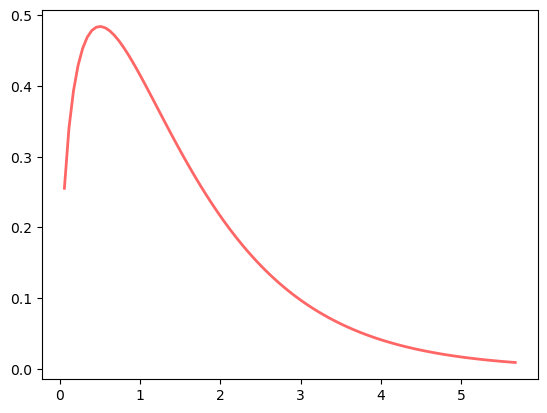

In [3]:
# Draw probability density function for choosen distribution
x = np.linspace(gamma.ppf(0.01, a), gamma.ppf(0.99, a), 100)
print(x[-1])
plt.plot(x, gamma.pdf(x, a), 'r-', lw=2, alpha=0.6, label='gamma pdf');

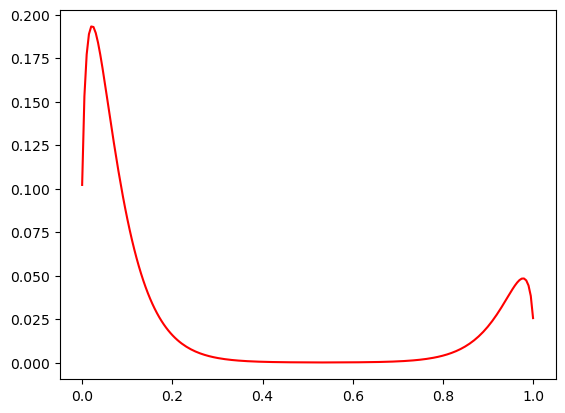

In [4]:
x2 = np.linspace(gamma.ppf(0.01, a), 10., 100)
y2 = gamma.pdf(x2, a)
x3 = np.linspace(0., 1., 200)
y3 = np.hstack((0.4 * y2, 0.1 * y2[::-1]))
plt.plot(x3, y3, 'r-');

In [5]:
class User:
    def __init__(self, startPeriod, utilityFuncGenerator):
        self.start = startPeriod
        self.richness = User.getRichness()
        self.basket = np.zeros(TOKENS_NUM)
        self.utilityCoeffs = User.getUtilityCoeffs()
        self.utilityFunc = utilityFuncGenerator(self)
        
    def getIncome(self):
        newIncome = self.richness * INCOME_VECTOR * rand.uniform(INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN, TOKENS_NUM)
        self.basket += newIncome
        return newIncome
    
    def seizeBasket(self):
        basket = self.basket
        self.basket = np.zeros(TOKENS_NUM)
        return basket
    
    def addToBasket(self, income):
        self.basket += income
        
    @property
    def utility(self):
        return self.utilityFunc(self.basket)
                
    @staticmethod
    def getRichness():
        return randWrapper(1, rand_type)
    
    @staticmethod
    def getUtilityCoeffs():
        return UTILITY_RANGES * randWrapper(TOKENS_NUM, rand_type)

In [6]:
def getObjective(users, lin_task=False):   
    coeffs = np.array([], dtype=float)
    if not isinstance(users, list):
        users = [users]
    for user in users:
        coeffs = np.append(coeffs, user.utilityCoeffs)

    if lin_task:
        return (-1.0) * coeffs
    
    def objective(x, sign=1.0):
        x_scaled = np.array([SCALING_FACTOR * x[0], SCALING_FACTOR * x[1], x[2]]) # Scaling is neccessary for proper work of SLSQP algorithm
        return sign * np.sum(coeffs * x) / len(users)
    return objective   

def getBasket(users):
    basket = np.zeros(TOKENS_NUM, dtype=float)
    for user in users:
        basket += user.seizeBasket()
    return basket

def getConstraints(users_num, basket, link_task=False):
    if link_task:
        A = np.tile(np.eye(3), users_num)
        b = basket[:]
        cons = (A, b)
    else:
        cons = ({  'type': 'eq'
                 , 'fun': lambda x: np.array(np.sum(x[::3]) - basket[0])
                },
                {  'type': 'eq'
                 , 'fun': lambda x: np.array(np.sum(x[1::3]) - basket[1])
                },
                {  'type': 'eq'
                 , 'fun': lambda x: np.array(np.sum(x[2::3]) - basket[2])
                })
    return cons

def getBounds(users_num):
    bnd = ((0, None),)
    return users_num * 3 * bnd

def optimize(users, users_num, obj_func, lin_task=False):
    basket = getBasket(users)
    constr = getConstraints(users_num, basket, lin_task)
    bnds = getBounds(users_num)
    if lin_task:
        res = scipy.optimize.linprog(
            obj_func,
            A_ub=constr[0],
            b_ub=constr[1],
            bounds=bnds
        )
    else:
        x0 = np.zeros(TOKENS_NUM * len(users))
        res = scipy.optimize.minimize(
            obj_func, 
            x0,
            args=(-1.0,), # sign = -1.0 for maximization
            method='SLSQP', 
            bounds=bnds, 
            constraints=constr, 
            tol=1e-6)
    return res

def calculateTotalUtility(users):
    utility = 0.0
    for user in users:
        utility += user.utility
    utility /= len(users)
    return utility

In [7]:
def simulate(epochs_num, obj_func_generator, lin_task=False, verbose=True):
    users = []
    dist_history = []
    for epoch in range(1, epochs_num + 1):
        newUser = User(epoch, obj_func_generator)
        users.append(newUser)
        for user in users:
            user.getIncome()
        util = calculateTotalUtility(users)
        if verbose:
            print(f"{epoch} epoch:")
            print(f"Utility before: {util}")
        obj_func = obj_func_generator(users, lin_task)
        # Save baskets if restore needed
        old_baskets = []
        for user in users:
            old_baskets.append(user.basket)
        res = optimize(users, len(users), obj_func, lin_task=lin_task)
        restore = False
        if verbose:
            if res.success:
                print("Optimization succeed.")
            else:
                print("Optimization failed!")
                print(res)
        if res.success:
            reshapedRes = np.reshape(res.x, (len(users), TOKENS_NUM))
            for ii, user in enumerate(users):
                user.addToBasket(reshapedRes[ii, :])
            new_util = calculateTotalUtility(users)
            if new_util < util:
                restore = True
        else:
            restore = True

        if restore:
            for user, old_basket in zip(users, old_baskets):
                _ = user.seizeBasket()
                user.addToBasket(old_basket)
        
        # Save current token distribution
        dist = []
        for user in users:
            dist.append(user.basket)
        dist_history.append(copy.deepcopy(dist))
            
        # Save info about epoch
        if verbose:
            util = calculateTotalUtility(users)
            print(f"Utility after: {util}")
            for user in users:
                print(user.utilityCoeffs)
            print("Baskets")
            for user in users:
                print(user.basket)
            print("======================")
    return dist_history

if USE_LINEAR_SOLVER:
    dist_history = simulate(EPOCHS_NUM, getObjective, lin_task=USE_LINEAR_SOLVER, verbose=True)
else:
    dist_history = simulate(EPOCHS_NUM, getObjective, verbose=True)

1 epoch:
Utility before: 35568.224043340306
Optimization succeed.
Utility after: 35568.224043340306
[    4.044     0.051 19861.395]
Baskets
[ 1503.713 14253.524     1.448]
2 epoch:
Utility before: 1963834.1061596337
Optimization succeed.
Utility after: 2406162.6900242534
[    4.044     0.051 19861.395]
[   7.398   18.432 2285.81 ]
Baskets
[ 0.     0.    22.794]
[ 21935.27  227721.609      0.   ]
3 epoch:
Utility before: 2848674.8376614195
Optimization succeed.
Utility after: 3113587.524835309
[    4.044     0.051 19861.395]
[   7.398   18.432 2285.81 ]
[  8.144   1.924 980.086]
Baskets
[ 0.     0.    43.955]
[     0.   440111.27      0.  ]
[43677.23     0.       0.  ]
4 epoch:
Utility before: 3310450.6446177885
Optimization succeed.
Utility after: 3699091.630928454
[    4.044     0.051 19861.395]
[   7.398   18.432 2285.81 ]
[  8.144   1.924 980.086]
[  18.625    2.346 1541.411]
Baskets
[ 0.     0.    65.435]
[     0.    666270.476      0.   ]
[0. 0. 0.]
[65298.812     0.        0.   ]

[ [1. 1. 1.] ]
[ [0. 0. 1.] [1. 1. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [1. 0. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [0. 0. 0.] [1. 0. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [0. 0. 0.] [1. 0. 0.] [0. 0. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [0. 0. 0.] [1. 0. 0.] [0. 0. 0.] [0. 0. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [1. 0. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [1. 0. 0.] [0. 0. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [1. 0. 0.] ]
[ [0. 0. 1.] [0. 1. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [0. 0. 0.] [1. 0. 0.] [0. 0. 0.] ]


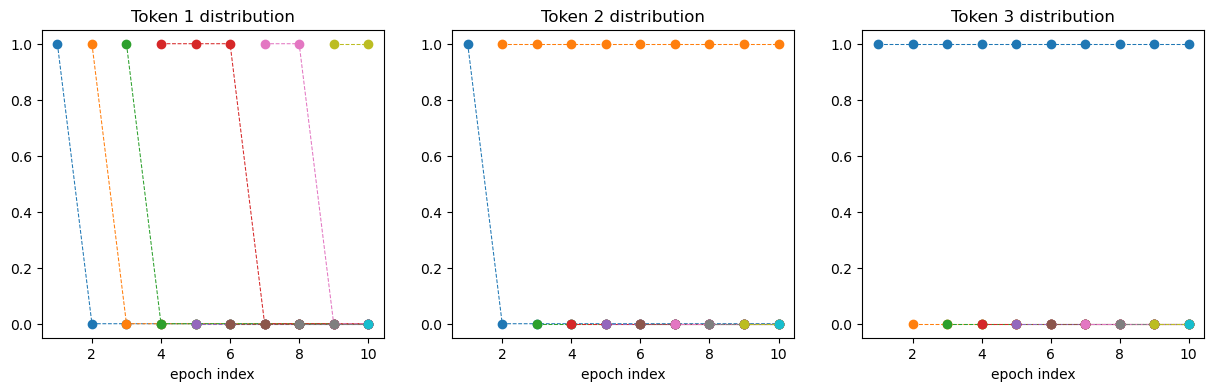

In [8]:
def calculate_token_dist_shares(dist_history, debug=True):
    # Calculate common baskets for all epochs
    epochs_num = len(dist_history)
    baskets = []
    for dist in dist_history:
        basket = np.zeros(3)
        for user_basket in dist:
            basket += user_basket
        baskets.append(basket)
    # Calculate distribution in shares
    dist_h_shares = copy.deepcopy(dist_history)
    for e in range(epochs_num):
        for ii in range(e + 1):
            dist_h_shares[e][ii] = dist_h_shares[e][ii] / baskets[e]
            
    if debug:
        for el in dist_h_shares:
            print(f"[", end=' ')
            for ii in range(len(el)):
                print(el[ii], end=' ')
            print(f"]")
    return dist_h_shares

def plot_token_dist(dist_h_shares):
    epochs_num = len(dist_h_shares)
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    for token_ind in range(TOKENS_NUM):
        ax[token_ind].set_title(f"Token {token_ind + 1} distribution")
        ax[token_ind].set_xlabel("epoch index")

        for user_ind in range(epochs_num):
            user_dist = []
            for epoch_ind in range(user_ind, epochs_num):
                user_dist.append(dist_h_shares[epoch_ind][user_ind][token_ind])
            ax[token_ind].plot(np.arange(user_ind + 1, epochs_num + 1), user_dist, marker='o', linestyle="--", linewidth=0.75)

dist_h_shares = calculate_token_dist_shares(dist_history, debug=True)
plot_token_dist(dist_h_shares)

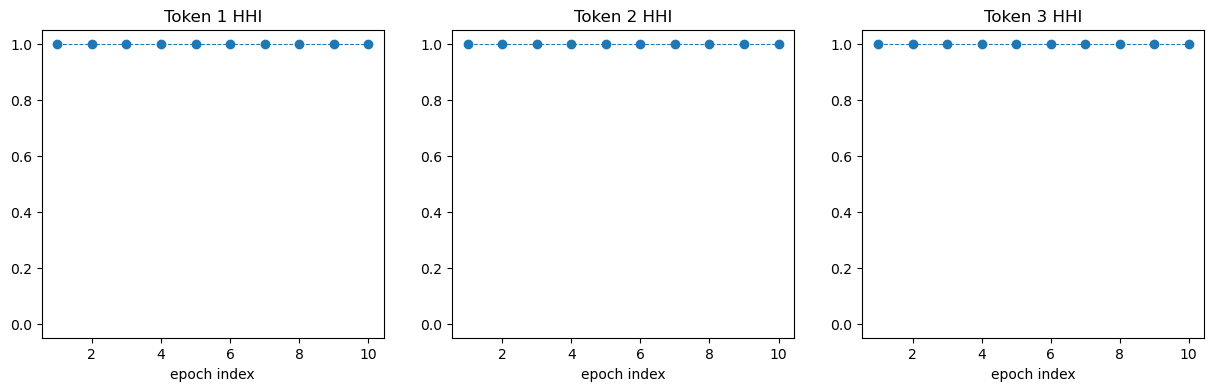

In [9]:
def plot_HHI(dist_h_shares):
    epochs_num = len(dist_h_shares)
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    for token_ind in range(TOKENS_NUM):
        ax[token_ind].set_title(f"Token {token_ind + 1} HHI")
        ax[token_ind].set_xlabel("epoch index")
        ax[token_ind].set_ylim(-.05, 1.05)

        hhi_by_epoch = []
        for epoch_dist in dist_h_shares:
            hhi = 0.
            for user_dist in epoch_dist:
                hhi += user_dist[token_ind]**2
            hhi_by_epoch.append(hhi)
        ax[token_ind].plot(np.arange(1, epochs_num + 1), hhi_by_epoch, marker='o', linestyle="--", linewidth=0.75)
        
plot_HHI(dist_h_shares)

In [10]:
# Simulate Utility function with natural logarithms
def getLogObjective(users, lin_task=False):
    assert lin_task == False, "Logarithm is not linear task!"
    coeffs = np.array([], dtype=float)
    if not isinstance(users, list):
        users = [users]
    for user in users:
        coeffs = np.append(coeffs, user.utilityCoeffs)
    
    def objective(x, sign=1.0):
        x_scaled = np.array([SCALING_FACTOR * x[0], SCALING_FACTOR * x[1], x[2]]) # Scaling is neccessary for proper work of SLSQP algorithm
        return sign * np.sum(coeffs * np.log(x + 1)) / len(users)
    return objective

dist_history = simulate(EPOCHS_NUM, getLogObjective, verbose=True)
dist_h_shares = calculate_token_dist_shares(dist_history, debug=False)

1 epoch:
Utility before: 10242.284004425337
Optimization succeed.
Utility after: 10242.284004425337
[    6.725    17.812 19148.014]
Baskets
[ 679.581 6720.792    0.689]
2 epoch:
Utility before: 10986.962837735931
Optimization succeed.
Utility after: 30275.230753908152
[    6.725    17.812 19148.014]
[ 188.211    1.072 1090.68 ]
Baskets
[   690.567 100083.017     19.937]
[19375.934 99583.744     0.193]
3 epoch:
Utility before: 21987.033127718427
Optimization succeed.
Utility after: 26045.40814796922
[    6.725    17.812 19148.014]
[ 188.211    1.072 1090.68 ]
[  14.893    1.678 4061.772]
Baskets
[  1777.148 131923.099     32.291]
[ 35600.026 131659.222      0.896]
[  2175.239 131659.427      6.062]
4 epoch:
Utility before: 35121.5002872996
Optimization succeed.
Utility after: 37738.22309434878
[    6.725    17.812 19148.014]
[ 188.211    1.072 1090.68 ]
[  14.893    1.678 4061.772]
[    8.074     0.842 19531.08 ]
Baskets
[  2967.258 193686.333     35.28 ]
[ 69939.535 193682.148      1.1

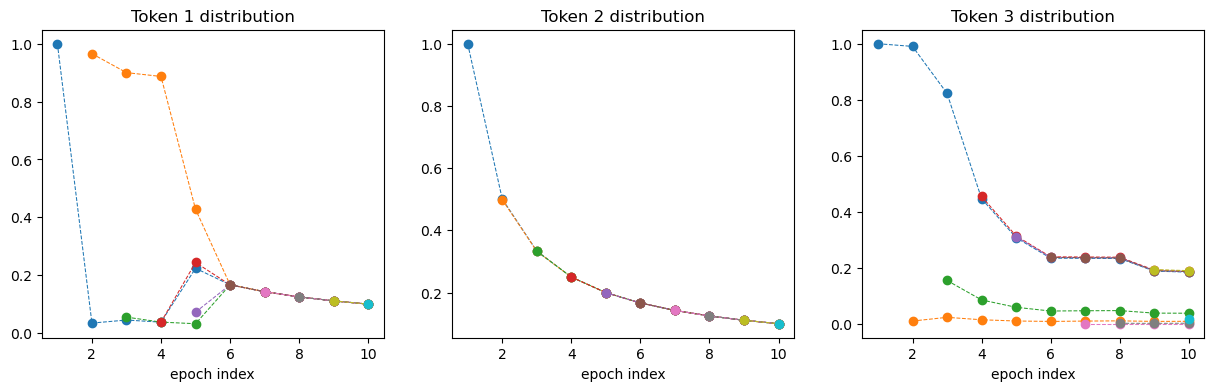

In [11]:
plot_token_dist(dist_h_shares)

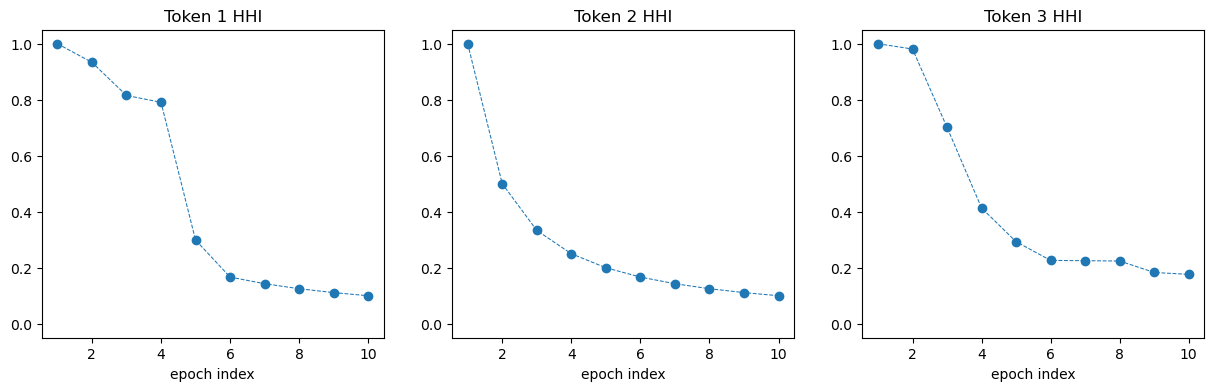

In [12]:
plot_HHI(dist_h_shares)

# AMM Modeling

In [13]:
class AMM:
    def __init__(self, x, y, z):
        self.liquidity = [x, y, z]
        self.k = x * y * z

    def swap(self, data):
        token_inds = {0, 1, 2}
        tx_ind = data[1]
        rx_ind = data[2]
        swap_pair = {tx_ind, rx_ind}
        unused_ind = token_inds - swap_pair
        unused_ind = unused_ind.pop()

        res = self.k / self.liquidity[unused_ind] / (self.liquidity[tx_ind] + data[0]) - self.liquidity[rx_ind]
        assert res < 0, "Oops! Error during swap!"
        self.liquidity[tx_ind] += data[0]
        self.liquidity[rx_ind] += res
        ret = np.zeros(3)
        ret[tx_ind] = -data[0]
        ret[rx_ind] = -res
        return ret


def calculateOptimalTransaction(user, amm):
    ''' return (amount, ind_tx, ind_rx) where
        - amount - amount of transmitted token for exchange
        - ind_tx - index of token transmitted to AMM
        - ind_rx - index of desired token from AMM
    '''
    
    # Same for all cases   
    obj_func = lambda x: (-1) * user.utilityFunc(user.basket - x)
    x0 = np.zeros(TOKENS_NUM)
    def AMM_constr(x):
        return (amm.liquidity[0] + x[0])*(amm.liquidity[1] + x[1])*(amm.liquidity[2] + x[2]) - amm.k

    curr_utility = user.utility
    opt_res = None
    
    for unused in range(TOKENS_NUM):
        token_inds = {0, 1, 2}
        swap_pair = tuple(token_inds - {unused})
            
        constr = [
            {'type': 'eq', 'fun': AMM_constr},
            {'type': 'ineq', 'fun': lambda x: (-1)*x[swap_pair[0]]*x[swap_pair[1]] - np.finfo(float).eps} # x*y < 0
        ]

        bnds = [None, None, None]
        bnds[swap_pair[0]] = (None, user.basket[swap_pair[0]])
        bnds[swap_pair[1]] = (None, user.basket[swap_pair[1]])
        bnds[unused] = (0, 0)
        bnds = tuple(bnds)  # x <= basket_x, y <= basket_y, z == 0
    
        res = scipy.optimize.minimize(
            obj_func, 
            x0,
            method='SLSQP', 
            bounds=bnds, 
            constraints=constr, 
            tol=1e-6,
            options={'maxiter': 10000})

        if not res.success:
            continue

        assert res.x[unused] < 1e-7, "Optimization failed: unused token changed value!"
        assert res.x[swap_pair[0]] * res.x[swap_pair[1]] < 0, "Optimization failed: x*y >= 0!"
        if res.x[swap_pair[0]] > 0:
            assert res.x[swap_pair[0]] <= user.basket[swap_pair[0]], "Optimization failed: transmitted more tokens than you had!"
        else:
            assert res.x[swap_pair[1]] <= user.basket[swap_pair[1]], "Optimization failed: transmitted more tokens than you had!"

        opt_utility = (-1) * obj_func(res.x)
        if opt_utility > curr_utility:
            curr_utility = opt_utility
            opt_res = (res.x[swap_pair[0]], swap_pair[0], swap_pair[1]) if res.x[swap_pair[0]] > 0 else (res.x[swap_pair[1]], swap_pair[1], swap_pair[0])

    return opt_res
    

def simulateAMM(epochs_num, obj_func_generator, amm, verbose=False):
    users = []
    baskets_history = []
    for epoch in range(epochs_num):
        tx_pool = []
        user = User(epoch + 1, obj_func_generator)
        users.append(user)
        for user in users:
            user.getIncome()
        if verbose:
            util = calculateTotalUtility(users)
            print(f"epoch {epoch + 1}")
            print(f"Utility before: {util}")
        for u_ind, user in enumerate(users):
            # Every user calculates his transaction regardless of others.
            user_tx = calculateOptimalTransaction(user, amm)
            if verbose:
                if user_tx is None:
                    print("Optimization Failed!")                   
                else:
                    print("Optimization succeed.")
            if user_tx is not None:
                tx_pool.append((u_ind, user_tx))
        # Shuffle transactions (order of transactions' execution is unknown)
        np.random.shuffle(tx_pool)
        # Execute all transaction sequentially
        for tx in tx_pool:
            exchange_res = amm.swap(tx[1])
            users[tx[0]].addToBasket(exchange_res)
        # Save state for history
        baskets = []
        for user in users:
            baskets.append(user.basket)
        baskets_history.append(copy.deepcopy(baskets))
        
        if verbose:
            util = calculateTotalUtility(users)
            print(f"Utility after: {util}")
            for user in users:
                print(user.utilityCoeffs)
            print("Baskets")
            for user in users:
                print(user.basket)
            print("======================")
    return baskets_history

In [14]:
myswap = AMM(AMM_LIQUIDITY_TOKEN0, AMM_LIQUIDITY_TOKEN1, AMM_LIQUIDITY_TOKEN2)
baskets_history = simulateAMM(EPOCHS_NUM, getObjective, myswap, verbose=True)
dist_h_shares = calculate_token_dist_shares(baskets_history, debug=False)

epoch 1
Utility before: 60679.93640042275
Optimization succeed.
Utility after: 103650.94272521847
[  35.515    0.473 1080.688]
Baskets
[ 2725.223 14512.045     0.   ]
epoch 2
Utility before: 140859.8070859344
Optimization succeed.
Optimization succeed.
Utility after: 200640.3643646885
[  35.515    0.473 1080.688]
[ 28.133   3.542 978.498]
Baskets
[6249.738    0.       1.575]
[ 1799.575 35854.29      0.   ]
epoch 3
Utility before: 249486.56946104395
Optimization succeed.
Optimization succeed.
Optimization succeed.
Utility after: 295203.2062745761
[  35.515    0.473 1080.688]
[ 28.133   3.542 978.498]
[ 198.699    2.731 1974.902]
Baskets
[ 8812.779 14736.26      0.   ]
[ 3698.051 68389.613     0.   ]
[1005.498 7174.367    0.   ]
epoch 4
Utility before: 366878.57650156476
Optimization succeed.
Optimization succeed.
Optimization succeed.
Optimization succeed.
Utility after: 442245.46206128795
[  35.515    0.473 1080.688]
[ 28.133   3.542 978.498]
[ 198.699    2.731 1974.902]
[  198.494    

C:\miniconda3\envs\dsp\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization succeed.
Optimization succeed.
Optimization succeed.
Optimization succeed.
Utility after: 515311.114218332
[  35.515    0.473 1080.688]
[ 28.133   3.542 978.498]
[ 198.699    2.731 1974.902]
[  198.494    18.622 19373.758]
[ 23.303   0.841 682.166]
Baskets
[15473.633 15467.646     0.   ]
[  1735.372 180723.076      3.756]
[3679.765    0.       1.388]
[  571.741 23333.083     0.   ]
[ 1507.939 11938.379     0.   ]
epoch 6
Utility before: 532180.2798862195
Optimization succeed.
Optimization succeed.
Optimization succeed.
Optimization succeed.
Optimization succeed.
Optimization succeed.
Utility after: 551683.1697588796
[  35.515    0.473 1080.688]
[ 28.133   3.542 978.498]
[ 198.699    2.731 1974.902]
[  198.494    18.622 19373.758]
[ 23.303   0.841 682.166]
[ 22.918   1.381 822.503]
Baskets
[18119.578     0.        1.442]
[  4180.643 198815.596      0.   ]
[4757.875    0.       2.069]
[ 1244.617 28628.905     0.   ]
[4434.971    0.       1.195]
[398.298   0.      0.337]
epoc

C:\Users\Hypotalamus\AppData\Local\Temp\ipykernel_13008\1085803349.py:14: RuntimeWarning: invalid value encountered in true_divide
  dist_h_shares[e][ii] = dist_h_shares[e][ii] / baskets[e]


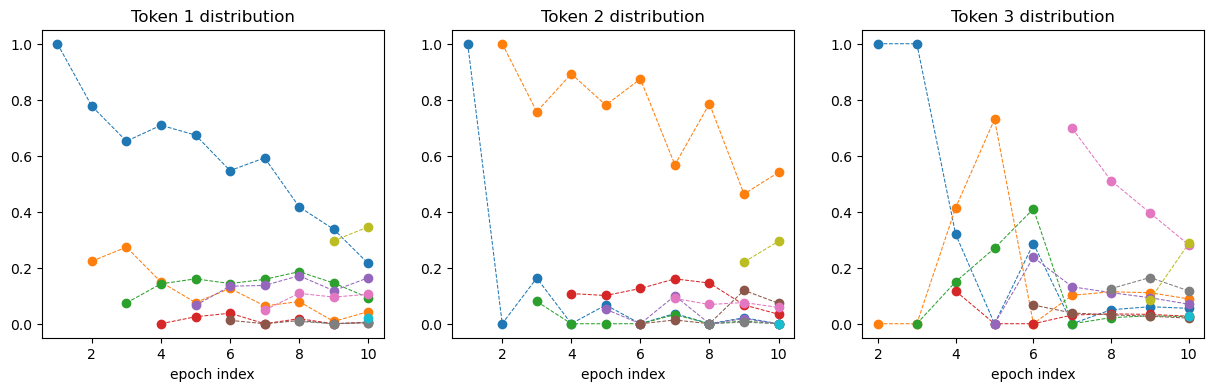

In [15]:
plot_token_dist(dist_h_shares)